In [ ]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("../content/train.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
data.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
data.shape

(7613, 5)

# EDA

## 1. Number of caracteres in tweets

In [ ]:
data["numberOfcaractere"] = data.text.str.len()

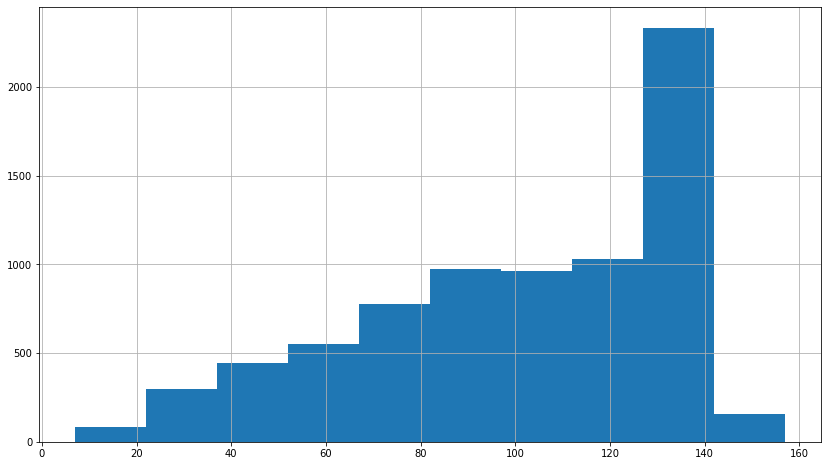

In [ ]:
data.numberOfcaractere.hist(figsize=(14,8))

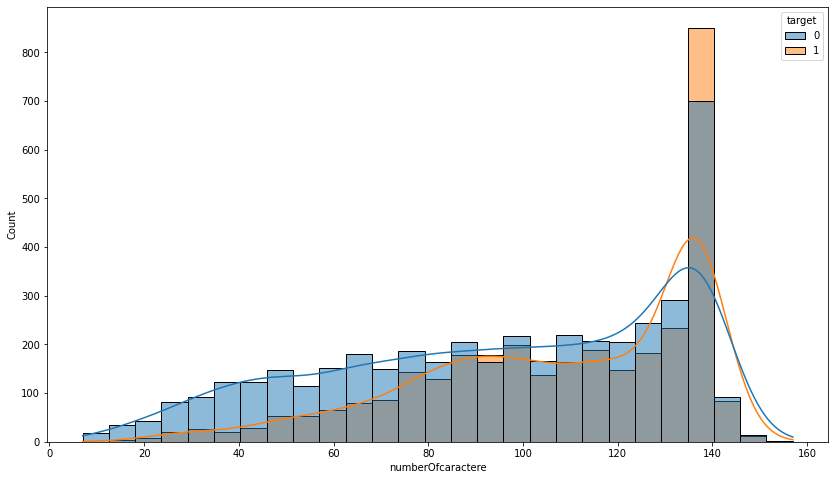

In [ ]:
plt.figure(figsize=(14,8))
sns.histplot(x="numberOfcaractere", data=data, hue="target", kde=True)

## 2. Number of words

In [ ]:
data["numberOfWords"] = data.text.str.split().map(lambda x: len(x))
#data.text.str.split().map( lambda x : len(x)).hist(figsize=(14,8))

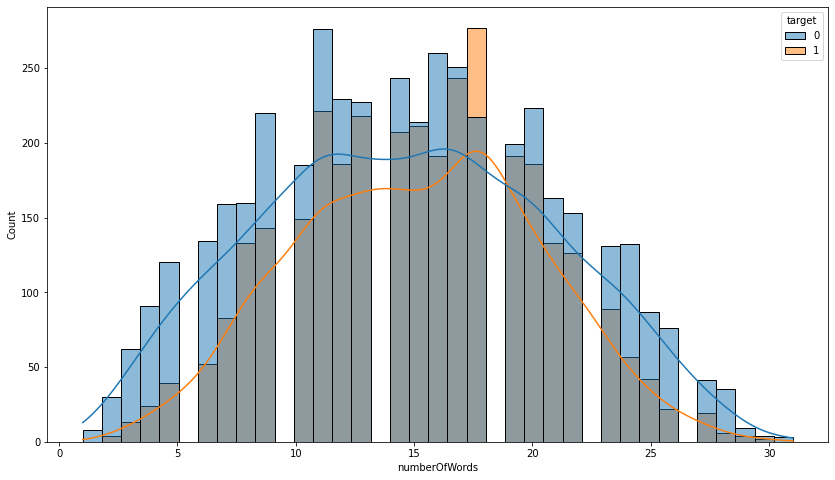

In [ ]:
plt.figure(figsize=(14,8))
sns.histplot(x="numberOfWords", data=data, hue="target", kde=True)

## 3. Location

In [ ]:
data.location.value_counts()

USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
One World                        1
austin, texas                    1
OES 4th Point. sisSTAR & TI      1
Boulder                          1
Hartford, Connecticut            1
Name: location, Length: 3341, dtype: int64

In [ ]:
data.location.isnull().value_counts()

False    5080
True     2533
Name: location, dtype: int64

## 3. Target

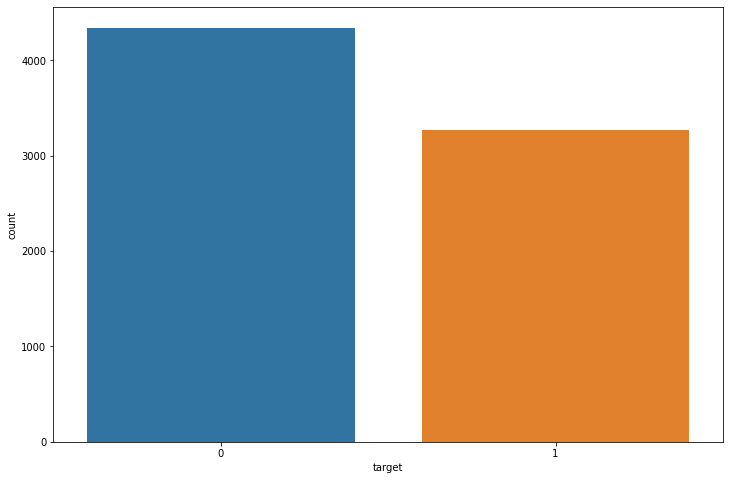

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="target", data=data)

# TEXT PROCESSING

In [ ]:
#preprocessing

import string
import re

def remove_url(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_ablazeWord(text):
    return text.replace("ablaze", "")

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

def remove_tripleDot(text):
    return text.replace('\u2026', "")

def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
data["text"] = data.text.map(remove_url)
data["text"] = data.text.map(remove_punct)
data["text"] = data.text.map(remove_tripleDot)
data["text"] = data.text.map(remove_emojis)
data["text"] = data.text.map(remove_ablazeWord)

In [ ]:
#remove stop word

from spacy.lang.en import STOP_WORDS

stopwords = set(STOP_WORDS)

nlp = spacy.load('en_core_web_sm')

def remove_stopword(text):
    filleterd_text = [word.lemma_.lower() for word in nlp.tokenizer(text) if not word.text.lower() in stopwords]
    return " ".join(filleterd_text)

In [ ]:
data["text"] = data.text.map(remove_stopword)

# WORDCLOUD

In [ ]:
from wordcloud import WordCloud

comment_words = ''
  
# iterate through the csv file
for val in data.text:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10,
                colormap='Set2', collocations=False).generate(comment_words)

In [ ]:
def plot_word(wordcloud):
    plt.figure(figsize = (20, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

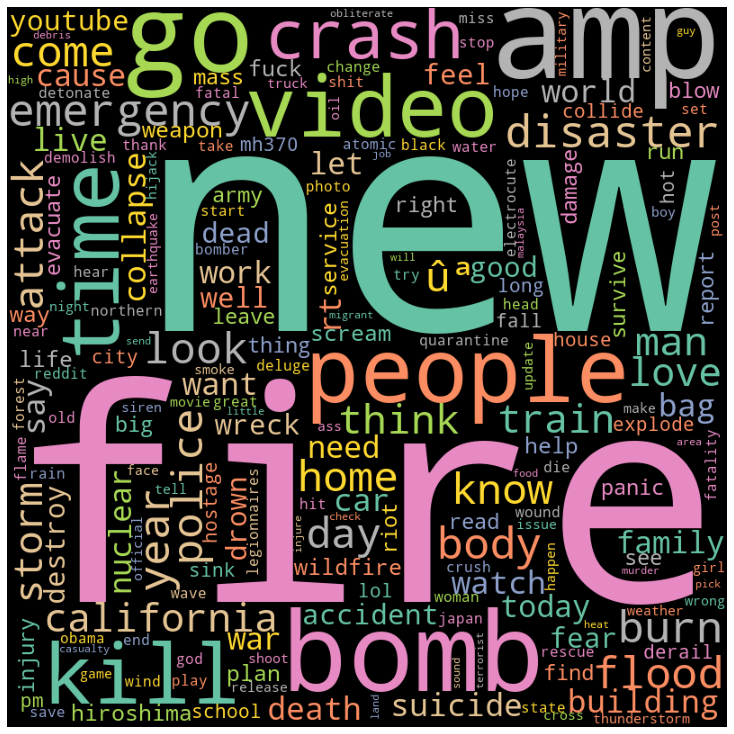

In [ ]:
# plot_word(wordcloud=wordcloud)

# MODEL

In [ ]:
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## 1. SVM

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

In [ ]:
X = data.text
y = data["target"]

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_df=0.9, min_df=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
dense = tfidf_matrix.todense()
dense.shape

(7613, 1262)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
svm = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)),TfidfTransformer(), SVC(kernel="linear", gamma="auto", C=2, random_state=0))

In [ ]:
def evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))
    print(classification_report(y_true=y_test, y_pred=y_pred))

    # N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4)
    # plt.figure(figsize=(12,8))
    # plt.plot(N, train_score.mean(axis=1), label='train score')
    # plt.plot(N, val_score.mean(axis=1), label='validation score')
    # plt.legend()

In [ ]:
evaluate(svm)

[[756 130]
 [178 459]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       886
           1       0.78      0.72      0.75       637

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



## 2.Build NN for text classification

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input, Embedding, SpatialDropout1D, GlobalAvgPool1D, GlobalMaxPool1D
from tensorflow.keras.models import Model

In [ ]:
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding= padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding= padding_type, truncating=trunc_type)

In [ ]:
vocab_size= len(word_index) + 1
embedding_dim = 16

In [ ]:
vocab_size

14347

In [ ]:
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_labels = np.array(y_train)
test_labels = np.array(y_test)

In [ ]:
print(train_padded.shape)
print(test_padded.shape)
print(train_labels.shape)

(6090, 50)
(1523, 50)
(6090,)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size,output_dim= embedding_dim, input_length=max_length),
    keras.layers.GlobalAvgPool1D(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation='sigmoid')
])

optRm = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model.compile(loss="binary_crossentropy", optimizer=optRm, metrics=["accuracy"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            229552    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 230,641
Trainable params: 230,641
Non-trainable params: 0
________________________________________________

In [ ]:
history = model.fit(train_padded, train_labels, validation_split=.1, epochs=20, batch_size=32)

Epoch 1/20
172/172 [==============================] - 1s 4ms/step - loss: 0.6834 - accuracy: 0.5672 - val_loss: 0.6793 - val_accuracy: 0.5698
Epoch 2/20
172/172 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5672 - val_loss: 0.6675 - val_accuracy: 0.5698
Epoch 3/20
172/172 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6181 - val_loss: 0.6063 - val_accuracy: 0.6847
Epoch 4/20
172/172 [==============================] - 0s 3ms/step - loss: 0.5254 - accuracy: 0.7820 - val_loss: 0.5277 - val_accuracy: 0.7619
Epoch 5/20
172/172 [==============================] - 0s 3ms/step - loss: 0.4132 - accuracy: 0.8371 - val_loss: 0.5248 - val_accuracy: 0.7438
Epoch 6/20
172/172 [==============================] - 0s 3ms/step - loss: 0.3600 - accuracy: 0.8566 - val_loss: 0.5110 - val_accuracy: 0.7816
Epoch 7/20
172/172 [==============================] - 0s 3ms/step - loss: 0.3325 - accuracy: 0.8644 - val_loss: 0.5199 - val_accuracy: 0.7734
Epoch 

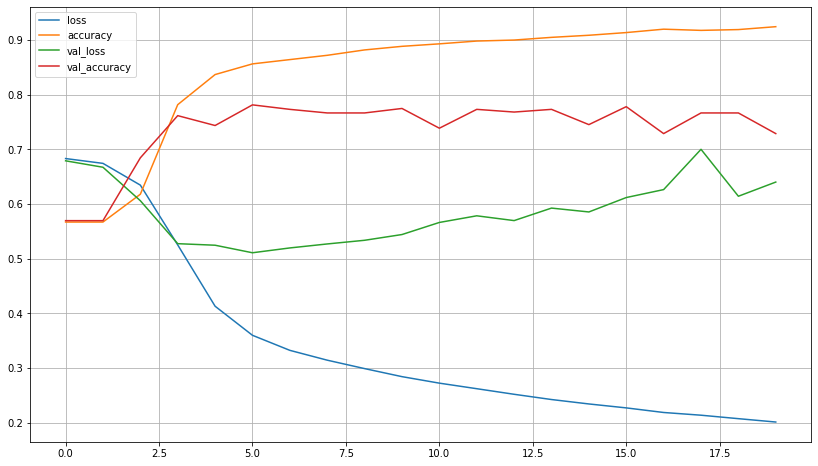

In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(14,8))
plt.grid(True)

In [ ]:
y_pred = model.predict(test_padded)
y_final = np.array([1 if pred > .5 else 0 for pred in y_pred])
y_final

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
print(confusion_matrix(y_true=y_test, y_pred=y_final))
print(classification_report(y_true=y_test, y_pred=y_final))

[[688 198]
 [137 500]]
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       886
           1       0.72      0.78      0.75       637

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [ ]:
!pip install pyspellchecker

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string # Library for string operations

import os

# plotly library
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

import matplotlib.pyplot as plt #Another plotting libraray

# word cloud library
from wordcloud import WordCloud

#Regex library
import re

#Spell Checker
from spellchecker import SpellChecker 
spell = SpellChecker()

<a id="section-four"></a>
# Loading Data

In [ ]:
TrainDataSet= pd.read_csv('../content/train.csv')
TestDataSet=pd.read_csv('../content/test.csv')
TrainDataSet.head(3)



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


<a id="section-five"></a>
# Exploratory Data Analysis of Tweets

<a id="subsection-1.1"></a>
### ***Show percentage of tweets marked as Disaster tweets** 

In [ ]:
#Importing all the necessary libraries
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('../content/train.csv')
print('The shape of the dataset=',df.shape)
df.head()

The shape of the dataset= (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


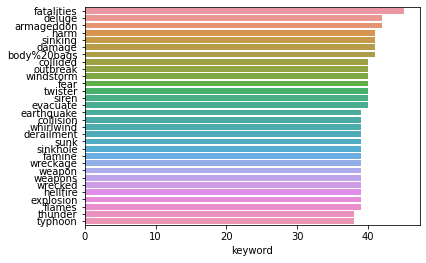

In [ ]:
sns.barplot(y=df['keyword'].value_counts()[:30].index,x=df['keyword'].value_counts()[:30])


In [ ]:
# A Disaster tweet
disaster_tweets=df[df['target']==1]['text']
disaster_tweets.values[1]

# Non Disaster tweets
nondisaster_tweets=df[df['target']==0]['text']
nondisaster_tweets.values[1]

'I love fruits'

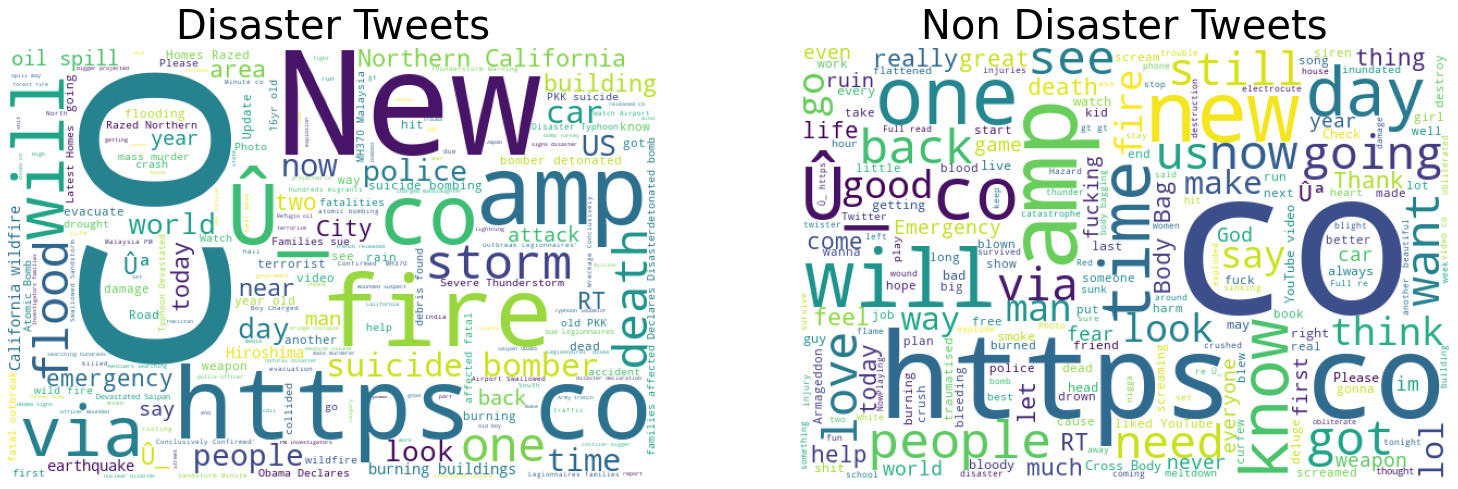

In [ ]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(nondisaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

##Modeling

In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
